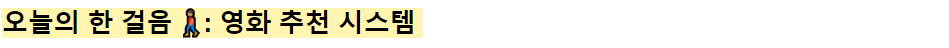

## Contexts

### 1. READY
    1-1 오늘의 Exp와 Rubric  
    1-2 사용하는 라이브러리  

### 2. GAME
    2-1. 데이터 읽어오기  
    2-2. 데이터 전처리  
    2-3. 데이터 분석
    2-4. 모델 생성
        -1. CSR matrix 
        -2. MF 모델 학습
        
    2-5. 데이터 평가   

### 3. POTG (best Play Of The Game
    3-1. 소감(POTG)  
    3-2. 어려웠던 점과 극복방안  
    3-3. 추후  

---


# 1. Ready
## 1-1. 오늘의 Exp와 Rubric




오늘은 Movielens 데이터를 통해 영화 추천 시스템을만들어보도록 한다.

오늘의 Rubric 은 다음과 같다.

|평가문항|상세기준|
|---|---|
|1. CSR matrix가 정상적으로 만들어졌다.|사용자와 아이템 개수를 바탕으로 정확한 사이즈로 만들었다.|
|2. MF 모델이 정상적으로 훈련되어 그럴듯한 추천이 이루어졌다.|사용자와 아이템 벡터 내적수치가 의미있게 형성되었다.|
|3. 비슷한 영화 찾기와 유저에게 추천하기의 과정이 정상적으로 진행되었다.|MF모델이 예측한 유저 선호도 및 아이템간 유사도, 기여도가 의미있게 측정되었다.|



## 1-2. 사용하는 라이브러리

In [1]:
import pandas as pd
import numpy as np

import os
import datetime as dt
from pathlib import Path
import matplotlib.pyplot as plt

from implicit.als import AlternatingLeastSquares #추천 모델
from scipy.sparse import csr_matrix # 추천 알고리즘 라이브러리


import warnings
warnings.filterwarnings('ignore')

# 2. GAME
## 2-1. 데이터 읽어오기

이번에 활용할 데이터셋은 추천 시스템의 MNIST라고 부를만한 Movielens 데이터 이다.



In [2]:


rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 2-2.데이터 전처리

In [3]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [4]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)

In [5]:
ratings['counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

In [6]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
# movie_id 를 통해 title을 얻을 수 있도록 dictionary 생성
movie_dic = {}
for i in range(len(movies)):
    movie_dic[movies.values[i][0]] = movies.values[i][1]

In [8]:
# ratings에 새로운 열 추가
mv_title = []
for i in range(len(ratings)):
    mv_title.append(movie_dic[ratings.values[i][1]])

ratings['title'] = mv_title

In [9]:
ratings.head()


,user_id,movie_id,counts,timestamp,title
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975)
1,1,661,3,978302109,James and the Giant Peach (1996)
2,1,914,3,978301968,My Fair Lady (1964)
3,1,3408,4,978300275,Erin Brockovich (2000)
4,1,2355,5,978824291,"Bug's Life, A (1998)"


## 2-3.데이터 분석

In [10]:
# ratings에 있는 유니크한 영화 개수
ratings['movie_id'].nunique()

3628

In [11]:
ratings['title'].nunique()

3628

In [12]:
# ratings에 있는 유니크한 사용자 수
ratings['user_id'].nunique()

6039

In [13]:
# 가장 인기 있는 영화 30개(인기순)
movie_count = ratings.groupby('title')['user_id'].count()
movie_count_30 = movie_count.sort_values(ascending=False).head(30)
movie_count_30

title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257
Pr

내가 선호하는 영화를 5개 골라 Ratings 에 추가했다.

In [14]:
# 내가 좋아하는 영화 5개
my_favorite = ['Showman' , 'Toystory' ,'spongebob' ,'Lionking' ,'Sing']

# 'HA'라는 user_id가 영화에 별점 5점씩.
my_movie = pd.DataFrame({'user_id': ['Ha']*5, 'title': my_favorite, 'counts':[5]*5})

if not ratings.isin({'user_id':['Ha']})['user_id'].any():  # user_id에 'Hong'이라는 데이터가 없다면
    ratings = ratings.append(my_movie)                      # 위에 임의로 만든 my_favorite 데이터를 추가해 줍니다. 

ratings.tail(10)       # 잘 추가되었는지 확인해 봅시다.

,user_id,movie_id,counts,timestamp,title
1000203,6040,1090.0,3,956715518.0,Platoon (1986)
1000205,6040,1094.0,5,956704887.0,"Crying Game, The (1992)"
1000206,6040,562.0,5,956704746.0,Welcome to the Dollhouse (1995)
1000207,6040,1096.0,4,956715648.0,Sophie's Choice (1982)
1000208,6040,1097.0,4,956715569.0,E.T. the Extra-Terrestrial (1982)
0,Ha,NaN,5,NaN,Showman
1,Ha,NaN,5,NaN,Toystory
2,Ha,NaN,5,NaN,spongebob
3,Ha,NaN,5,NaN,Lionking
4,Ha,NaN,5,NaN,Sing


In [15]:
# 고유한 유저, 아티스트를 찾아내는 코드
user_unique = ratings['user_id'].unique()
title_unique = ratings['title'].unique()

# 유저, 아티스트 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
title_to_idx = {v:k for k,v in enumerate(title_unique)}

In [16]:
# 인덱싱이 잘 되었는지 확인해 봅니다. 
print(user_to_idx['Ha'])    # 358869명의 유저 중 마지막으로 추가된 유저이니 358868이 나와야 합니다. 
print(title_to_idx['Sing'])

6039
3632


In [17]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = ratings['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(ratings):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    ratings['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# title_to_idx을 통해 title 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_title_data = ratings['title'].map(title_to_idx.get).dropna()
if len(temp_title_data) == len(ratings):
    print('title column indexing OK!!')
    ratings['movie_id'] = temp_title_data
else:
    print('title column indexing Fail!!')

ratings


user_id column indexing OK!!
title column indexing OK!!


,user_id,movie_id,counts,timestamp,title
0,0,0,5,978300760.0,One Flew Over the Cuckoo's Nest (1975)
1,0,1,3,978302109.0,James and the Giant Peach (1996)
2,0,2,3,978301968.0,My Fair Lady (1964)
3,0,3,4,978300275.0,Erin Brockovich (2000)
4,0,4,5,978824291.0,"Bug's Life, A (1998)"
...,...,...,...,...,...
0,6039,3628,5,NaN,Showman
1,6039,3629,5,NaN,Toystory
2,6039,3630,5,NaN,spongebob
3,6039,3631,5,NaN,Lionking


## 2.4 모델 생성
### 2-4-1. CSR matrix 만들기

CSR matrix :  Sparse한 matrix에서 0이 아닌 유효한 데이터로 채워지는 데이터의 값과 좌표 정보만으로 구성하여 메모리 사용량을 최소화하면서도 Sparse한 matrix와 동일한 행렬을 표현할 수 있도록 하는 데이터 구조


In [18]:
num_user = ratings['user_id'].nunique()
num_movie_id = ratings['movie_id'].nunique()

csr_data = csr_matrix((ratings.counts, (ratings.user_id, ratings.movie_id)), shape= (num_user, num_movie_id))
csr_data

<6040x3633 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

In [19]:
# implicit 라이브러리에서 권장하고 있는 부분입니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

als_model = AlternatingLeastSquares(factors=200, regularization=0.01, use_gpu=False, iterations=20, dtype=np.float32)


factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지  
regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지  
use_gpu : GPU를 사용할 것인지  
iterations : epochs와 같은 의미입니다. 데이터를 몇 번 반복해서 학습할 것인지  

In [20]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3633x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

### 2-4-2. 모델 학습

In [21]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/20 [00:00<?, ?it/s]

## 2-4.데이터 평가

In [22]:
Ha, Sing = user_to_idx['Ha'], title_to_idx['Sing']
Ha_vector, Sing_vector = als_model.user_factors[Ha], als_model.item_factors[Sing]


In [23]:
Ha_vector

array([ 0.00751417, -0.101845  ,  0.05712584, -0.16308928, -0.03277985,
       -0.04986611,  0.0337227 ,  0.09287469,  0.0344944 ,  0.0410362 ,
        0.0024997 ,  0.03680173, -0.07802711,  0.09651607, -0.14732069,
        0.11819708,  0.06549343,  0.02697443, -0.06921803,  0.02554797,
        0.03316654,  0.10022967,  0.04948491,  0.07185426,  0.04957498,
        0.00363182, -0.00236359,  0.10560187, -0.00327458,  0.05677547,
        0.02593433, -0.06413838, -0.03929678, -0.06070546, -0.07285542,
        0.00470842, -0.03027994,  0.07881375, -0.02730515,  0.05253988,
       -0.0686364 , -0.05693533,  0.07249079, -0.04111919, -0.14418763,
       -0.03100552,  0.04273528, -0.10440595, -0.02317088, -0.01394536,
       -0.03297644, -0.02363133, -0.12587036,  0.04196518,  0.17392929,
        0.0182784 ,  0.10901149, -0.0022103 ,  0.02856014, -0.0050237 ,
       -0.107889  ,  0.02087657,  0.05229021, -0.05432286, -0.08069189,
        0.05551942, -0.01163971, -0.09820157,  0.00167415, -0.09

In [24]:
# Hong과 Joker를 내적하는 코드
np.dot(Ha_vector, Sing_vector)

0.014562528

### 사용해보기

In [25]:
favorite_movie = 'Sing'
movie_id = title_to_idx[favorite_movie]
similar_movie = als_model.similar_items(movie_id, N=15)
similar_movie

[(3629, 0.9999999),
 (3630, 0.9999999),
 (3632, 0.9999999),
 (3631, 0.99999946),
 (3628, 0.9999229),
 (3615, 0.9989038),
 (3549, 0.99835813),
 (3035, 0.9983533),
 (3531, 0.9978987),
 (3570, 0.997703),
 (3480, 0.99748445),
 (3496, 0.9974302),
 (3616, 0.9973477),
 (3053, 0.997323),
 (3589, 0.997289)]

In [26]:
#title_to_idx 를 뒤집어, index로부터 title 이름을 얻는 dict를 생성합니다. 
idx_to_title = {v:k for k,v in title_to_idx.items()}
[idx_to_title[i[0]] for i in similar_movie]

['Toystory',
 'spongebob',
 'Sing',
 'Lionking',
 'Showman',
 'Chain of Fools (2000)',
 'Make Them Die Slowly (Cannibal Ferox) (1980)',
 'For Ever Mozart (1996)',
 'Aiqing wansui (1994)',
 'Loser (1991)',
 'Back Stage (2000)',
 'Voyage to the Beginning of the World (1997)',
 'Song of Freedom (1936)',
 'Sunchaser, The (1996)',
 'Soft Toilet Seats (1999)']

In [27]:
# 함수로 만들기
def get_similar_title(movie_name: str):
    movie_id = title_to_idx[movie_name]
    similar_movie = als_model.similar_items(movie_id)
    similar_movie = [idx_to_title[i[0]] for i in similar_movie]
    return similar_movie

In [28]:
get_similar_title('For Ever Mozart (1996)')


['For Ever Mozart (1996)',
 'Showman',
 'Lionking',
 'Toystory',
 'spongebob',
 'Sing',
 'Chain of Fools (2000)',
 'Make Them Die Slowly (Cannibal Ferox) (1980)',
 'Aiqing wansui (1994)',
 'Song of Freedom (1936)']

결과적으로 내가 좋아한 영화들에 기반하여  
나에게 추천하는 영화들의 벡터값은 다음과 같다.

In [29]:
user = user_to_idx['Ha']
# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
movie_recommended

[(228, 0.028000504),
 (170, 0.026395697),
 (1716, 0.02297287),
 (706, 0.022776408),
 (1291, 0.022649264),
 (473, 0.022408128),
 (840, 0.021673992),
 (1553, 0.02149359),
 (811, 0.020922117),
 (817, 0.020585142),
 (2515, 0.020459477),
 (1888, 0.020274892),
 (3481, 0.020227658),
 (2250, 0.020166554),
 (945, 0.020111263),
 (2217, 0.020013882),
 (1194, 0.019919977),
 (58, 0.019795723),
 (3390, 0.019586043),
 (1379, 0.01954256)]

아래는 해당 벡터값들의 영화 이름이다.

In [30]:
[idx_to_title[i[0]] for i in movie_recommended]

['X-Files: Fight the Future, The (1998)',
 'Being John Malkovich (1999)',
 "Angela's Ashes (1999)",
 'L.A. Story (1991)',
 'Blood Simple (1984)',
 'Hurricane, The (1999)',
 'Simple Plan, A (1998)',
 'Slipper and the Rose, The (1976)',
 'Thomas Crown Affair, The (1999)',
 'Sneakers (1992)',
 'Life and Times of Hank Greenberg, The (1998)',
 'Algiers (1938)',
 'Man from Down Under, The (1943)',
 'Blood on the Sun (1945)',
 'Highlander (1986)',
 'Palookaville (1996)',
 'Fatal Attraction (1987)',
 'Mission: Impossible (1996)',
 'All Things Fair (1996)',
 'Hitch-Hiker, The (1953)']

# 3. POTG
## 3-1. 소감

#### "😎 오케이 일단 추천시스템의 원리는 알겠어! "

사람이 직관하기 어려울 정도의 차원에서, 컴퓨터는 자료들의 위치값을 벡터로 저장하고  
내적을 통한 거리를 구합니다. 때문에 NLP 와 마찬가지로 자료의 임베딩(여기서는 MF 모델 생성) 과정이 중요합니다.


## 3-2. 어려웠던 점과 극복방안

1. CSR matirix 와 MF 모델에 대해 아직 이해가 부족한 것 같습니다. 
아직은 둘의 상관관계가 무엇인지 모르겠습니다.

2. 내적값에 문제가 있다고 판단됩니다.
본인이 평점을 높게 준 영화 외에,  
다른 것들에 대한 내적값, 즉 유사도가 너무 높게 나옵니다.

모델 생성과정의 문제라고 보는데, 하이퍼파라미터를 어떻게 바꿔야 할 지 모르겠습니다.
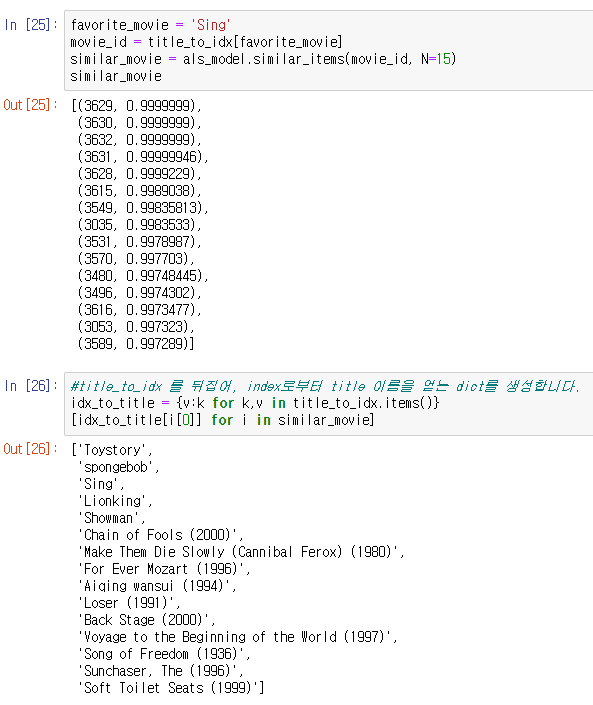



## 3-3. 추후

추천시스템은 NLP와 관련이 있다고 느끼는데, 아직 정확하게 어떤 교집합이 있는지 모릅니다.  
그 부분에 대해 좀 더 파헤쳐보고 싶습니다.